# Radar tracking EKF {-}

An aircraft is flying in a 2D coordinate frame with constant speed and altitude. The range to the arcraft is observed by radar.

Both speed and altitude are unknown.

State vector:
\begin{equation}
  x=
  \begin{bmatrix}
    pos\\
    vel\\
    alt\\
  \end{bmatrix}
  =
  \begin{bmatrix}
    x_1\\
    x_2\\
    x_3\\
  \end{bmatrix}
\end{equation}

Dynamic equation
\begin{equation}
  \begin{bmatrix}
    \dot{x_1}\\
    \dot{x_2}\\
    \dot{x_3}\\
  \end{bmatrix}
  =
  \begin{bmatrix}
    0 &1 &0\\
    0 &0 &0\\
    0 &0 &0\\
  \end{bmatrix}
  \begin{bmatrix}
    x_1\\
    x_2\\
    x_3\\
  \end{bmatrix}
  +
  \begin{bmatrix}
    0 &0\\
    \sqrt{q_v} &0\\
    0 &\sqrt{q_h}\\
  \end{bmatrix}
  u(t)
\end{equation}

Observation equation
\begin{equation}
  r=\sqrt{x_1^2 + x_3^2} + v
\end{equation}

In [1]:
from sympy import Matrix, diff, symbols, sqrt

x1, x2, x3, r = symbols('x1 x2 x3 r')

# Measurement equation
r = sqrt(x1**2 + x3**2)

# Design matrix (linearized)
H = Matrix([[r]])
dH = H.jacobian([x1, x2, x3])
dH

Matrix([[x1/sqrt(x1**2 + x3**2), 0, x3/sqrt(x1**2 + x3**2)]])

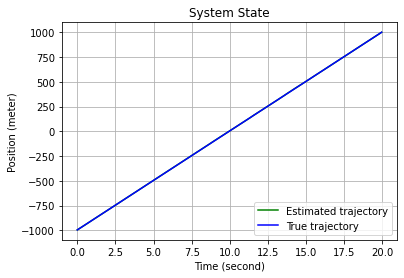

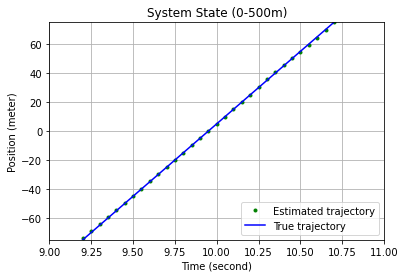

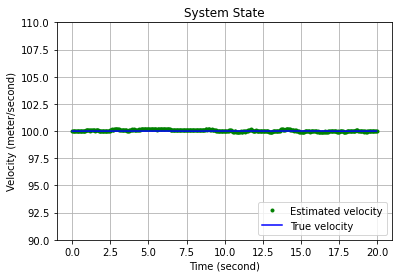

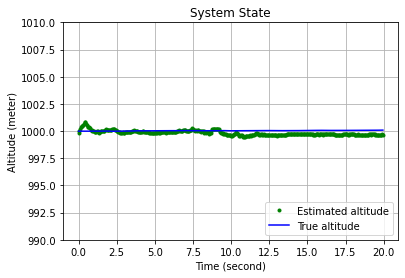

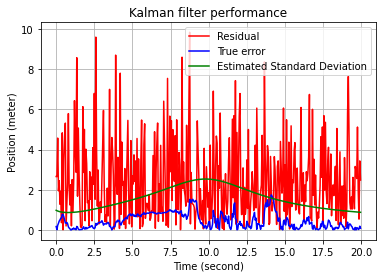

In [2]:
from numpy import arange, array, eye, sqrt, zeros, random, diag
from numpy.linalg import inv, norm, cholesky
import matplotlib.pyplot as plt
from lib.vanloan import numeval

# System values
dt = 0.05       # [second]
samples = 400   # number of samples
num = 3         # number of iterations (design matrix)
qv = 0.01       # [meter^2/second^3]
qh = 0.01       # [meter^2/second]

# Dynamics matrix
F = array([[0, 1, 0],
           [0, 0, 0],
           [0, 0, 0]])

# White noise coefficients
G = array([[0, 0],
           [sqrt(qv), 0],
           [0, sqrt(qh)]])

# Observation covariance matrix
R = array([[10]])  # meter^2

# Initial state
x = array([[-1000],
           [100],
           [1000]])
xt = x

# Inital state covariance matrix
P = diag([1, 0.1, 1])

# Numerical evaluation (van Loan)
[phi, Q] = numeval(F, G, dt)

# Cholesky decomposition of process noise covariance
C = cholesky(Q)

# Linearized design matrix
def dH(x_nom):
    
    x1 = x_nom[0, 0]
    x3 = x_nom[2, 0]

    dH = array([[x1/sqrt(x1**2 + x3**2), 0, x3/sqrt(x1**2 + x3**2)]])
    
    return dH

# Computed observations
def hx(x_nom):
    
    x1 = x_nom[0, 0]
    x3 = x_nom[2, 0]
    
    z = array([[sqrt(x1**2 + x3**2)]])
    
    return z

# Plot vectors
x_all = []; P_all = []; xt_all =[]
res = []; err = []

# Main loop
for k in range(0, samples):
    
    # Process noise vector
    w = array([[0],
               [random.normal(0, sqrt(qv))],
               [random.normal(0, sqrt(qh))]])
    
    # Compute true trajectory
    xt = phi@xt + C@w
    
    # Generate noisy measurements
    z = hx(xt) + random.normal(0, sqrt(R[0, 0]))
    
    # Time update
    xp = phi@x
    Pp = phi@P@phi.T + Q
    
    # Iterations
    for k in range(0, num):
        
        # Design matrix
        H = dH(xp)
    
        # System size
        (n, e) = H.shape
        
        # Predicted observations
        zp = hx(xp)
    
        # Kalman gain
        K = Pp@H.T@inv(H@Pp@H.T + R)
    
        # Measurement update
        x = xp + K@(z - zp)
        P = (eye(e) - K@H)@Pp@(eye(e) - K@H).T + K@R@K.T
    
    # Accumulate plot vectors
    x_all.append(x)
    P_all.append(P)
    xt_all.append(xt)

    res.append(norm(z - zp))
    err.append(norm(xt[0] - x[0]))
    

# Extract plot vectors
pos_est = [x[0] for x in x_all]
vel_est = [x[1] for x in x_all]
alt_est = [x[2] for x in x_all]

pos_true = [xt[0] for xt in xt_all]
vel_true = [xt[1] for xt in xt_all]
alt_true = [xt[2] for xt in xt_all]

std = [sqrt(P[0, 0]) for P in P_all]

# Time
time = arange(0, samples)*dt

plt.figure(1)
plt.plot(time, pos_est, 'g', label = 'Estimated trajectory')
plt.plot(time, pos_true, 'b', label = 'True trajectory')
plt.title('System State')
plt.xlabel('Time (second)')
plt.ylabel('Position (meter)')
plt.legend(loc='lower right')
plt.grid(True, which='both')
plt.show()

plt.figure(2)
plt.plot(time, pos_est, 'g.', label='Estimated trajectory')
plt.plot(time, pos_true, 'b', label='True trajectory')
plt.title('System State (0-500m)')
plt.xlabel('Time (second)')
plt.ylabel('Position (meter)')
plt.xlim(9, 11)
plt.ylim(-75, 75)
plt.legend(loc='lower right')
plt.grid(True, which='both')
plt.show()

plt.figure(3)
plt.plot(time, vel_est, 'g.', label='Estimated velocity')
plt.plot(time, vel_true, 'b', label='True velocity')
plt.title('System State')
plt.xlabel('Time (second)')
plt.ylabel('Velocity (meter/second)')
plt.ylim(90, 110)
plt.legend(loc='lower right')
plt.grid(True, which='both')
plt.show()

plt.figure(4)
plt.plot(time, alt_est, 'g.', label='Estimated altitude')
plt.plot(time, alt_true, 'b', label='True altitude')
plt.title('System State')
plt.xlabel('Time (second)')
plt.ylabel('Altitude (meter)')
plt.ylim(990, 1010)
plt.legend(loc='lower right')
plt.grid(True, which='both')
plt.show()

plt.figure(5)
plt.plot(time, res, 'r', label='Residual')
plt.plot(time, err, 'b', label='True error')
plt.plot(time, std, 'g', label='Estimated Standard Deviation')
plt.title('Kalman filter performance')
plt.xlabel('Time (second)')
plt.ylabel('Position (meter)')
plt.legend(loc='upper right')
plt.grid(True, which='both')
plt.show()